In [2]:
import pandas as pd 
import geopandas as gpd
import numpy as np

from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

import cemo_module as cemo

In [3]:
def streak(s:pd.Series):
    """
    Takes in a pandas series of boolean values and returns a series with a count of the number of cumulative true values.\n
    For heat events series must be restricted to a specific district and in order of dates.

    Arguments:
        s: Ordered boolean Pandas series
    
    """
    
    return np.multiply(s, s.cumsum()).diff().where(lambda x:x<0).ffill().add(s.cumsum(), fill_value=0)

def grouping(day):
    if day >= 2:
        return 'Heat Event'
    else:
        return 'Not a Heat Event'

### Pulling in Data

In [4]:
heat_df = pd.read_csv('data/District_Heat/District_Heat.csv')
heat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186354 entries, 0 to 186353
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   District         186354 non-null  int64  
 1   date_time        186354 non-null  object 
 2   heat_index_high  186354 non-null  float64
 3   heat_index_low   186354 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 5.7+ MB


In [5]:
#Process date and integer datatypes needed
heat_df['date_time'] = pd.to_datetime(heat_df['date_time']) 

#Sort on district and date, needed to calculate streaks acurately later on.
heat_df.sort_values(
    by=['District', 'date_time'],
    ascending=[True,True], 
    inplace=True
)
heat_df.head()

,District,date_time,heat_index_high,heat_index_low
0,1,2018-01-01,67.964050,44.975379
102,1,2018-01-02,75.183769,51.330571
204,1,2018-01-03,72.576000,51.703380
306,1,2018-01-04,72.901380,51.761742
408,1,2018-01-05,71.472715,53.012019


### Populaiton Join and Cleaning

In [6]:
lcva_fd_gdf = gpd.read_file('data/LCVA/LCVA_pop.gpkg')

In [7]:
pop_df = lcva_fd_gdf[['District', 'Population']]
pop_df['District'] = pop_df['District'].astype(int)

heat_df = pd.merge(heat_df, pop_df, on='District', how='left')

<ipython-input-7-d603204718aa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pop_df['District'] = pop_df['District'].astype(int)


In [8]:
ems_volumes = pd.read_csv('data/FireStatLA/ems_call_counts.csv', 
                          names=['District', 'date_time', 'calls'],
                          parse_dates=['date_time'], header=0)


In [9]:
ems_volumes = pd.read_csv('data/FireStatLA/ems_call_counts.csv', 
                          names=['District', 'date_time', 'calls'],
                          parse_dates=['date_time'], header=0)

#Joins heat data with call volumes
joined_df = heat_df.merge(ems_volumes, how="left", on=['District', 'date_time'])
joined_df.fillna(value=0, inplace=True) #Fills rows with no observation with zero
joined_df['calls'] = joined_df['calls'].astype(int)
joined_df.head()


,District,date_time,heat_index_high,heat_index_low,Population,calls
0,1,2018-01-01,67.964050,44.975379,37620.0,9
1,1,2018-01-02,75.183769,51.330571,37620.0,7
2,1,2018-01-03,72.576000,51.703380,37620.0,5
3,1,2018-01-04,72.901380,51.761742,37620.0,1
4,1,2018-01-05,71.472715,53.012019,37620.0,6


In [10]:
joined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186354 entries, 0 to 186353
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   District         186354 non-null  int64         
 1   date_time        186354 non-null  datetime64[ns]
 2   heat_index_high  186354 non-null  float64       
 3   heat_index_low   186354 non-null  float64       
 4   Population       186354 non-null  float64       
 5   calls            186354 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 10.0 MB


In [11]:
joined_df['calls_per_10000'] = (joined_df['calls']/joined_df['Population'])*10000
joined_df['calls_per_10000'].describe()

count    186354.000000
mean          7.835280
std          60.953518
min           0.000000
25%           1.306943
50%           1.964347
75%           2.806274
max        1435.185185
Name: calls_per_10000, dtype: float64

In [12]:
joined_df[joined_df['calls_per_10000']>1000]

,District,date_time,heat_index_high,heat_index_low,Population,calls,calls_per_10000
82217,51,2018-01-03,73.606045,52.937724,216.0,24,1111.111111
82230,51,2018-01-16,68.015853,52.783706,216.0,29,1342.592593
82239,51,2018-01-25,64.176939,46.438566,216.0,23,1064.814815
82246,51,2018-02-01,71.017795,50.795713,216.0,25,1157.407407
82250,51,2018-02-05,69.889313,50.844503,216.0,22,1018.518519
...,...,...,...,...,...,...,...
83012,51,2020-03-08,62.624640,50.061407,216.0,22,1018.518519
83019,51,2020-03-15,61.790888,52.624889,216.0,23,1064.814815
83805,51,2022-05-10,65.073646,50.379679,216.0,23,1064.814815
83993,51,2022-11-14,67.888305,45.642080,216.0,22,1018.518519


These wildly high call rates all seem to be coming from district 51 and are because of the low population. This district is the same district LAX which is likely responsible both for a very high rate of calls and for the low population.

In [13]:
joined_df[joined_df['District']!=51]['calls_per_10000'].describe()

count    184527.000000
mean          2.432127
std           2.714550
min           0.000000
25%           1.294767
50%           1.947609
75%           2.766124
max          47.021944
Name: calls_per_10000, dtype: float64

These seem at least a little more reasonable, I'm still curious about the high value, but it is at least in the realm of maybe being reasonable

In [14]:
no_lax = joined_df[joined_df['District']!=51]
no_lax[no_lax['calls_per_10000']>15]['District'].unique()

array([ 4,  9, 40, 95])

4 and 9 are downtown, 40 is the harbor, and 95 is also near LAX, all places that make sense to have a higher call rate within their own area. To account for this I can standardize by the average call rate in each given fire district to give the ratio of the rate of calls to the average rate of calls in the district.

In [15]:
district_avg = joined_df.groupby('District')['calls_per_10000'].mean().rename('District_Avg')

In [16]:
rate_df = joined_df.merge(district_avg, on='District', how='left')
rate_df['normalized_rate'] = rate_df['calls_per_10000']/rate_df['District_Avg']
rate_df.head()

,District,date_time,heat_index_high,heat_index_low,Population,calls,calls_per_10000,District_Avg,normalized_rate
0,1,2018-01-01,67.964050,44.975379,37620.0,9,2.392344,1.931713,1.238457
1,1,2018-01-02,75.183769,51.330571,37620.0,7,1.860712,1.931713,0.963245
2,1,2018-01-03,72.576000,51.703380,37620.0,5,1.329080,1.931713,0.688032
3,1,2018-01-04,72.901380,51.761742,37620.0,1,0.265816,1.931713,0.137606
4,1,2018-01-05,71.472715,53.012019,37620.0,6,1.594896,1.931713,0.825638


In [17]:
rate_df['normalized_rate'].describe()

count    186354.000000
mean          1.000000
std           0.528309
min           0.000000
25%           0.711726
50%           0.966258
75%           1.245116
max          10.747059
Name: normalized_rate, dtype: float64

Coeficient:0.0015816922506758319


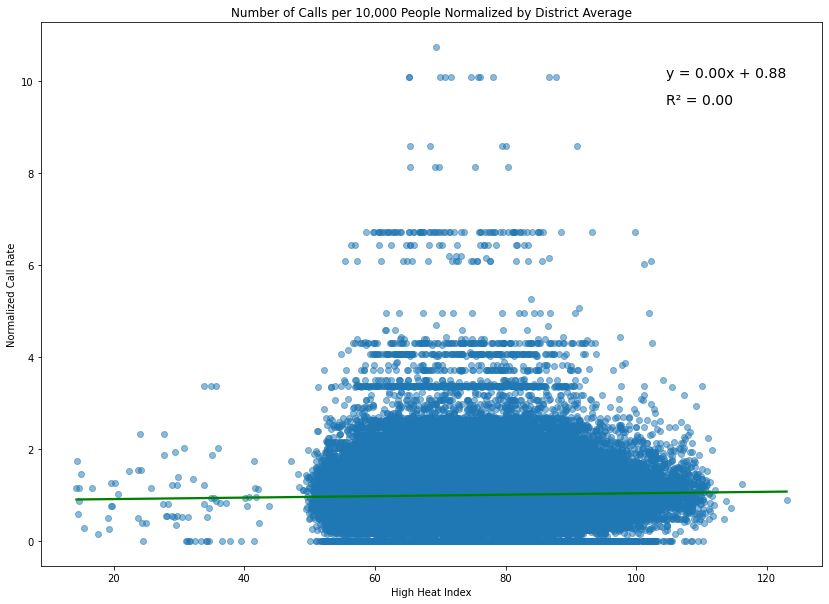

In [18]:
data = rate_df
x_col = 'heat_index_high'
y_col = 'normalized_rate'

fig, ax = plt.subplots(figsize=(14,10))
sns.regplot(data=data, x=x_col, y=y_col, ax=ax, line_kws={"color": "green"}, scatter_kws={'alpha':.5})

x_data = data[x_col].values.reshape(-1,1)
y_data = data[y_col].values.reshape(-1,1)

reg = LinearRegression()
reg.fit(x_data, y_data)

equation = 'y = {:.2f}x + {:.2f}'.format(reg.coef_[0][0], reg.intercept_[0])
r_squared = 'R² = {:.2f}'.format(reg.score(x_data, y_data))
plt.text(0.8, 0.9, equation, fontsize=14, transform=plt.gca().transAxes)
plt.text(0.8, 0.85, r_squared, fontsize=14, transform=plt.gca().transAxes)

plt.ylabel('Normalized Call Rate')
plt.xlabel('High Heat Index')
plt.title('Number of Calls per 10,000 People Normalized by District Average')
print('Coeficient:' + str(reg.coef_[0][0]))

plt.show()

Coeficient:-0.18384012319903886


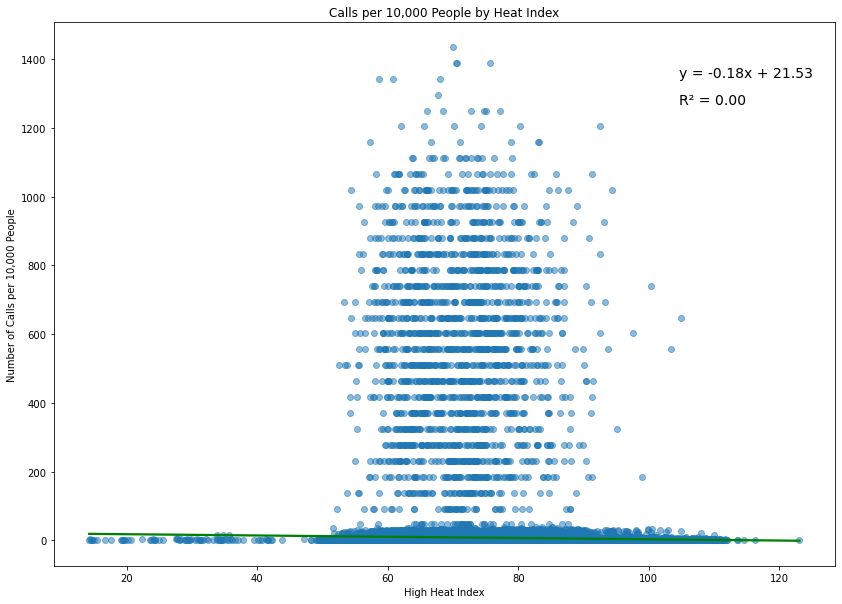

In [19]:
data = rate_df
x_col = 'heat_index_high'
y_col = 'calls_per_10000'

fig, ax = plt.subplots(figsize=(14,10))
sns.regplot(data=data, x=x_col, y=y_col, ax=ax, line_kws={"color": "green"}, scatter_kws={'alpha':.5})

x_data = data[x_col].values.reshape(-1,1)
y_data = data[y_col].values.reshape(-1,1)

reg = LinearRegression()
reg.fit(x_data, y_data)

equation = 'y = {:.2f}x + {:.2f}'.format(reg.coef_[0][0], reg.intercept_[0])
r_squared = 'R² = {:.2f}'.format(reg.score(x_data, y_data))
plt.text(0.8, 0.9, equation, fontsize=14, transform=plt.gca().transAxes)
plt.text(0.8, 0.85, r_squared, fontsize=14, transform=plt.gca().transAxes)

plt.ylabel('Number of Calls per 10,000 People')
plt.xlabel('High Heat Index')
plt.title('Calls per 10,000 People by Heat Index')
print('Coeficient:' + str(reg.coef_[0][0]))
plt.show()

Coeficient:0.006880848089539479


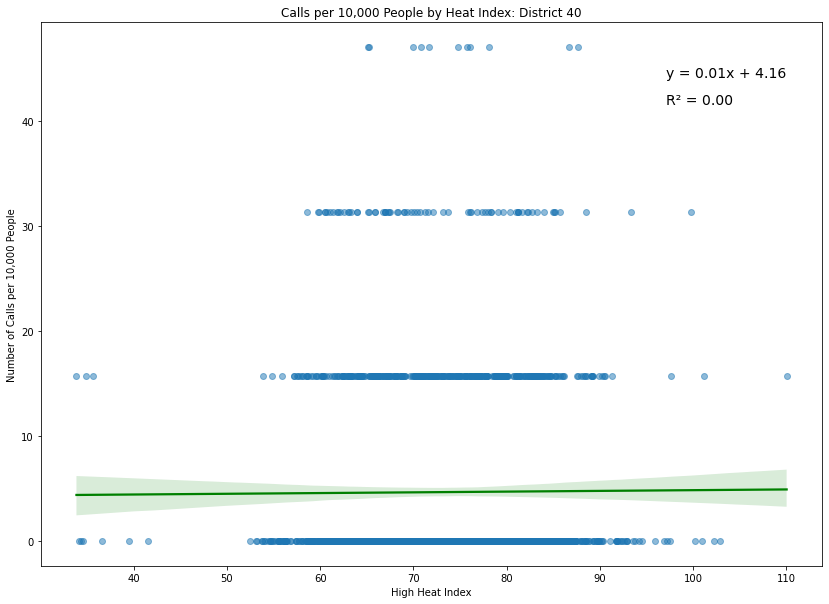

In [20]:
d = 40
data = rate_df[rate_df['District']==d]
x_col = 'heat_index_high'
y_col = 'calls_per_10000'

fig, ax = plt.subplots(figsize=(14,10))
sns.regplot(data=data, x=x_col, y=y_col, ax=ax, line_kws={"color": "green"}, scatter_kws={'alpha':.5})

x_data = data[x_col].values.reshape(-1,1)
y_data = data[y_col].values.reshape(-1,1)

reg = LinearRegression()
reg.fit(x_data, y_data)

equation = 'y = {:.2f}x + {:.2f}'.format(reg.coef_[0][0], reg.intercept_[0])
r_squared = 'R² = {:.2f}'.format(reg.score(x_data, y_data))
plt.text(0.8, 0.9, equation, fontsize=14, transform=plt.gca().transAxes)
plt.text(0.8, 0.85, r_squared, fontsize=14, transform=plt.gca().transAxes)

plt.ylabel('Number of Calls per 10,000 People')
plt.xlabel('High Heat Index')
plt.title(f'Calls per 10,000 People by Heat Index: District {d}')
print('Coeficient:' + str(reg.coef_[0][0]))
plt.show()

It appears that there may be some small association when looking within a given fire station district. When looking overall the noise may be to great to draw a reasonable association between call volumes and heat. 

Let's try aggregating up the call numbers and heat to the city level to see if there is an association overall.

In [21]:
#aggregate variables to city level for proof of correlation
city_df = rate_df.groupby('date_time').agg({'heat_index_high':'mean', 'Population':'sum', 'calls':'sum'}).reset_index()
#drop row with zero calls (Jan 1st 2023), outside the study bounds
city_df = city_df[city_df['calls']!=0]

city_df.head()

,date_time,heat_index_high,Population,calls
0,2018-01-01,67.802541,3971896.0,1043
1,2018-01-02,75.385213,3971896.0,947
2,2018-01-03,72.733515,3971896.0,958
3,2018-01-04,72.925009,3971896.0,927
4,2018-01-05,71.398980,3971896.0,983


Coeficient:1.4807756452396192


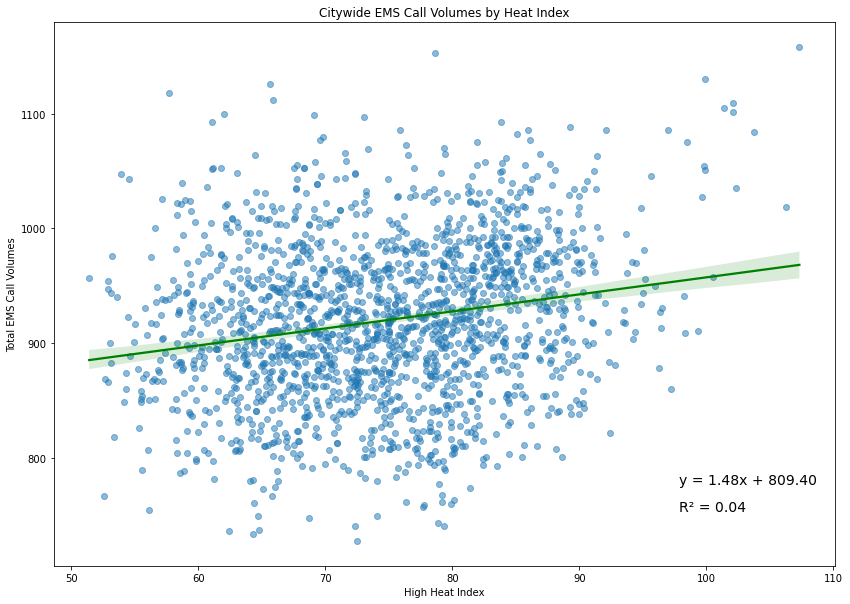

In [22]:
data = city_df
x_col = 'heat_index_high'
y_col = 'calls'

fig, ax = plt.subplots(figsize=(14,10))
sns.regplot(data=data, x=x_col, y=y_col, ax=ax, line_kws={"color": "green"}, scatter_kws={'alpha':.5})

x_data = data[x_col].values.reshape(-1,1)
y_data = data[y_col].values.reshape(-1,1)

reg = LinearRegression()
reg.fit(x_data, y_data)

equation = 'y = {:.2f}x + {:.2f}'.format(reg.coef_[0][0], reg.intercept_[0])
r_squared = 'R² = {:.2f}'.format(reg.score(x_data, y_data))
plt.text(0.8, 0.15, equation, fontsize=14, transform=plt.gca().transAxes)
plt.text(0.8, 0.1, r_squared, fontsize=14, transform=plt.gca().transAxes)

plt.ylabel('Total EMS Call Volumes')
plt.xlabel('High Heat Index')
plt.title('Citywide EMS Call Volumes by Heat Index')
print('Coeficient:' + str(reg.coef_[0][0]))
plt.show()


In [23]:
city_df['heat_day'] = np.vectorize(cemo.heat_threshold)(daily_high=city_df['heat_index_high'], high_thresh=90)
city_df['streak'] = streak(city_df['heat_day'])
city_df['Event'] = np.vectorize(grouping)(city_df['streak'])
city_df.head()


,date_time,heat_index_high,Population,calls,heat_day,streak,Event
0,2018-01-01,67.802541,3971896.0,1043,False,0.0,Not a Heat Event
1,2018-01-02,75.385213,3971896.0,947,False,0.0,Not a Heat Event
2,2018-01-03,72.733515,3971896.0,958,False,0.0,Not a Heat Event
3,2018-01-04,72.925009,3971896.0,927,False,0.0,Not a Heat Event
4,2018-01-05,71.398980,3971896.0,983,False,0.0,Not a Heat Event


Text(0.5, 1.0, 'Citywide Daily Call Distribution')

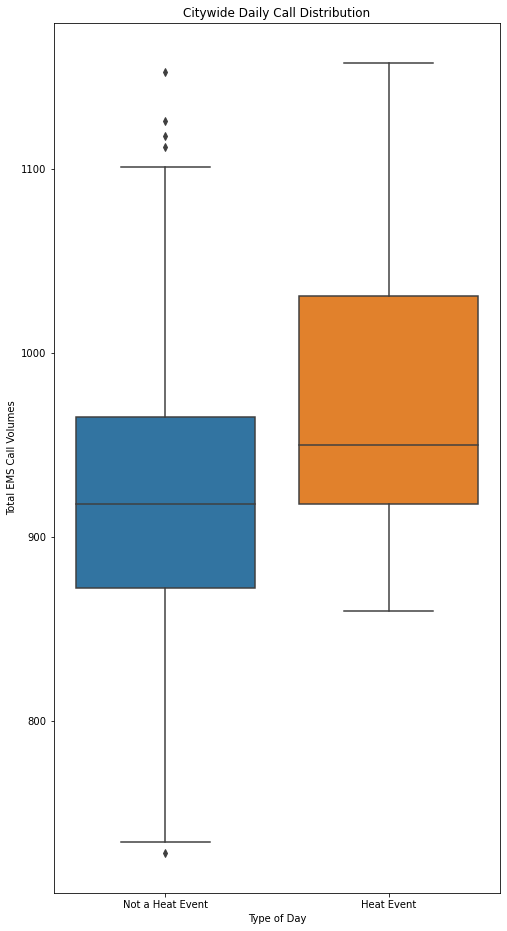

In [24]:
fig, ax = plt.subplots(figsize=(8, 16))
sns.boxplot(data=city_df, x='Event', y='calls', ax=ax)

plt.xlabel('Type of Day')
plt.ylabel('Total EMS Call Volumes')
plt.title('Citywide Daily Call Distribution')

In [25]:
p_val = stats.ttest_ind(city_df[city_df['streak']<2]['calls'], city_df[city_df['streak']>=2]['calls'], equal_var=False, alternative='less')[1]
print(f'Citywide P Value is: {p_val}')

Citywide P Value is: 3.327683325681453e-06


We can reject the null hypothesis, overall there is a statistically significant greater number of 911 calls on heat events where the temperature is over 90 than non heat events.

In [26]:
city_df.to_csv('data/Analysis/city_summary.csv', index=False)


### Heat Day Definitions
Heat Day definitions are tricky, at their simplist, definitions are above 90°F, but some definitions are 95°F, even 100°F in the Valley. Other definitions use over 90° during the day and over 70° at night. We can explore the heat day definitions later but for now we use the simplist definition: two or more days over 90°F

In [27]:
joined_df['heat_day'] = np.vectorize(cemo.heat_threshold)(daily_high=joined_df['heat_index_high'], high_thresh=90)
joined_df.head()

,District,date_time,heat_index_high,heat_index_low,Population,calls,calls_per_10000,heat_day
0,1,2018-01-01,67.964050,44.975379,37620.0,9,2.392344,False
1,1,2018-01-02,75.183769,51.330571,37620.0,7,1.860712,False
2,1,2018-01-03,72.576000,51.703380,37620.0,5,1.329080,False
3,1,2018-01-04,72.901380,51.761742,37620.0,1,0.265816,False
4,1,2018-01-05,71.472715,53.012019,37620.0,6,1.594896,False


In [28]:
districts = joined_df['District'].unique()

districts

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  23,  24,  25,  26,  27,
        28,  29,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
        44,  46,  47,  48,  49,  50,  51,  52,  55,  56,  57,  58,  59,
        60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,
        73,  74,  75,  76,  77,  78,  79,  81,  82,  83,  84,  85,  86,
        87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
       100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 112])

In [29]:
serieslist=[]
for district in districts:
    num_days = streak(joined_df[joined_df['District']==district]['heat_day'])
    serieslist.append(num_days)

streak_series = pd.concat(serieslist).rename('days_of_heat')

In [30]:
streak_df = joined_df.join(streak_series, how='left')
#Cross check random sample to ensure that join aligned appropriately
#Any day of 1 or higher should have a high heat index over 90
streak_df[streak_df['days_of_heat']>=1].sample(10) 

,District,date_time,heat_index_high,heat_index_low,Population,calls,calls_per_10000,heat_day,days_of_heat
86083,55,2018-08-03,90.668135,71.208979,31968.0,4,1.251251,True,1.0
9338,6,2018-07-23,94.619464,70.746124,72453.0,11,1.518226,True,1.0
153697,93,2018-08-18,90.695156,70.998966,43382.0,11,2.535614,True,4.0
35604,20,2020-06-10,90.389501,67.938118,44454.0,6,1.349710,True,1.0
167949,100,2022-08-20,90.445740,68.054631,40050.0,8,1.997503,True,16.0
162831,98,2018-08-17,91.604486,72.388027,97021.0,16,1.649128,True,3.0
10092,6,2020-08-15,98.423197,73.940190,72453.0,9,1.242185,True,2.0
167997,100,2022-10-07,90.183699,64.806498,40050.0,7,1.747815,True,1.0
9756,6,2019-09-14,94.388925,69.115656,72453.0,11,1.518226,True,2.0
181399,108,2019-06-11,91.688712,66.547118,4606.0,1,2.171081,True,2.0


In [31]:
def grouping(day):
    if day >= 2:
        return 'Heat Event'
    else:
        return 'Not a Heat Event'
    
streak_df['Event'] = np.vectorize(grouping)(streak_df['days_of_heat'])

Text(0.5, 1.0, 'Overall Call Distribution (Fewer than 40 per 10,000)')

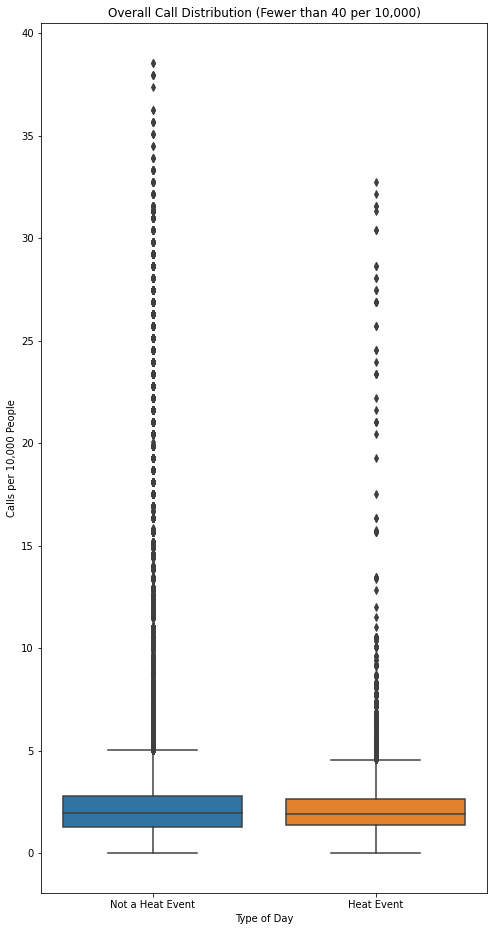

In [32]:
fig, ax = plt.subplots(figsize=(8, 16))
sns.boxplot(data=streak_df[streak_df['calls_per_10000']<40], x='Event', y='calls_per_10000', ax=ax)

plt.xlabel('Type of Day')
plt.ylabel('Calls per 10,000 People')
plt.title('Overall Call Distribution (Fewer than 40 per 10,000)')

Text(0.5, 1.0, 'Call Distribution by Heat Events: District 15')

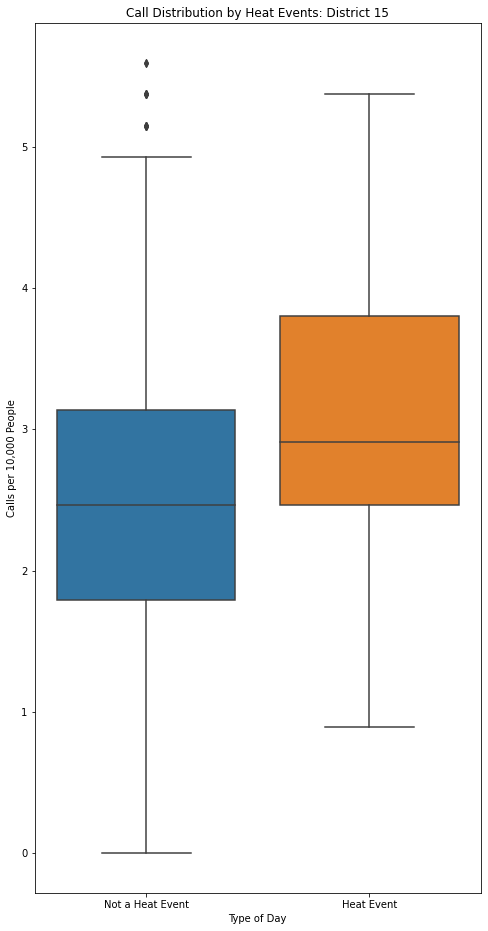

In [33]:
fig, ax = plt.subplots(figsize=(8, 16))
sns.boxplot(data=streak_df[streak_df['District']== 15], x='Event', y='calls_per_10000', ax=ax)

plt.xlabel('Type of Day')
plt.ylabel('Calls per 10,000 People')
plt.title('Call Distribution by Heat Events: District 15')

There does seem to be at least a little bit of something to this, but identifying across firestation districts may not work well. Districts are too different and the data is very noisy. We can map a ttest however.

In [34]:
#Create Dataframe of heat and no heat means with t test
p_value = []
no_heat_mean = []
heat_mean = []


for district in districts:
    test_df = streak_df[streak_df['District']==district]
    a = test_df[test_df['Event']== 'Not a Heat Event']['calls']
    b = test_df[test_df['Event']== 'Heat Event']['calls']

    
    p = stats.ttest_ind(a, b, equal_var=False, alternative='less')[1]

    p_value.append(p)
    no_heat_mean.append(a.mean())
    heat_mean.append(b.mean())

stat_df = pd.DataFrame({'District': districts,
                        'no_heat_mean': no_heat_mean,
                        'heat_mean': heat_mean,
                        't_test': p_value
                    }
)
stat_df.head()

,District,no_heat_mean,heat_mean,t_test
0,1,7.240471,8.372093,0.013194
1,2,10.548767,12.232558,0.009155
2,3,11.748322,12.025641,0.315189
3,4,16.054220,17.210526,0.098621
4,5,5.536680,5.357143,0.610268


In [37]:
stat_df.describe()

,District,no_heat_mean,heat_mean,t_test
count,102.000000,102.000000,102.000000,102.000000
mean,56.470588,8.991838,9.679304,0.212650
std,32.607691,6.592412,7.158930,0.258773
min,1.000000,0.297507,0.272727,0.000245
25%,27.250000,4.248887,5.067090,0.018449
50%,58.500000,7.771043,8.305094,0.098608
75%,84.750000,11.614106,12.443854,0.313804
max,112.000000,39.135271,41.657895,0.970652


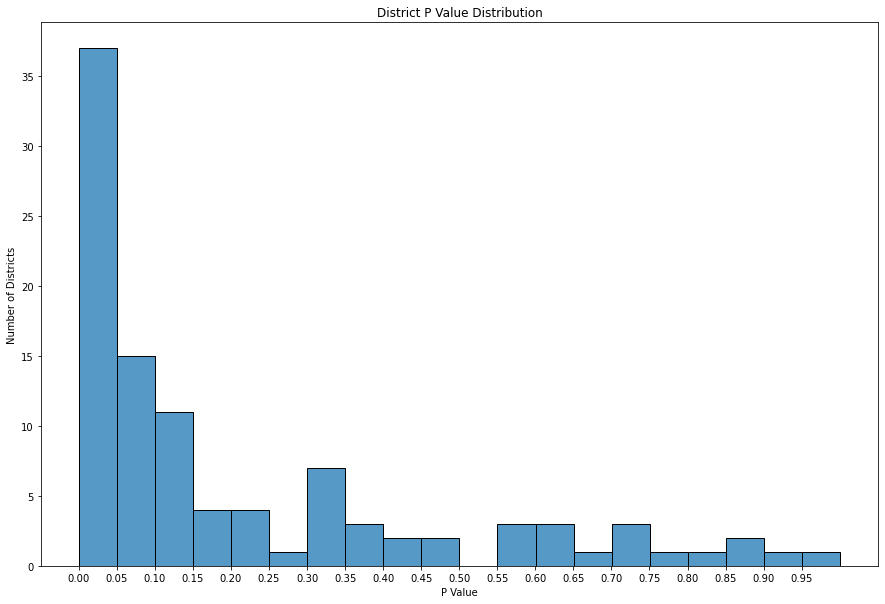

In [48]:
fig, ax = plt.subplots(figsize=(15,10))
sns.histplot(stat_df['t_test'], binwidth=.05, ax=ax)

plt.xlabel('P Value')
plt.ylabel('Number of Districts')
plt.title('District P Value Distribution')

plt.xticks(np.arange(0,1, step=.05))

plt.show()

In [55]:
streak_df.head()

,District,date_time,heat_index_high,heat_index_low,Population,calls,calls_per_10000,heat_day,days_of_heat,Event
0,1,2018-01-01,67.964050,44.975379,37620.0,9,2.392344,False,0.0,Not a Heat Event
1,1,2018-01-02,75.183769,51.330571,37620.0,7,1.860712,False,0.0,Not a Heat Event
2,1,2018-01-03,72.576000,51.703380,37620.0,5,1.329080,False,0.0,Not a Heat Event
3,1,2018-01-04,72.901380,51.761742,37620.0,1,0.265816,False,0.0,Not a Heat Event
4,1,2018-01-05,71.472715,53.012019,37620.0,6,1.594896,False,0.0,Not a Heat Event


In [56]:
stat_df.to_csv('data/Analysis/district_t_test.csv', index=False)
streak_df.to_csv('data/Analysis/90degreeheatday.csv', index=False)

